In [91]:
import numpy as np
import random
import gym
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from timeit import default_timer as timer
from datetime import timedelta
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv


In [92]:
def getTestPolicyRewards(env, policy, n_epoch=1000):
    rewards = []
    episodes = []
    for epoch in range(n_epoch):
        current_state = env.reset()
        ep = 0
        episode_reward = 0
        doneStatus = False
        while not doneStatus and ep < 1000:
            ep += 1
            action = int(policy[current_state])
            new_state, reward, doneStatus, _ = env.step(action)
            episode_reward += reward
            current_state = new_state
        rewards.append(episode_reward)
        episodes.append(ep)
    reward_mean = sum(rewards)/len(rewards)
    episode_mean = sum(episodes)/len(episodes)
    return reward_mean, episode_mean, rewards, episodes

def VI(env, discount=0.9, epsilon=1e-12):
    start = timer()
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    policy = np.zeros((1, num_states))
    value_list = np.zeros((1, num_states))
    value_list_old = value_list.copy()
    episode = 0
    max_change = 1
    sigma = discount
    
    while max_change > epsilon:
        episode += 1
        #print("added!!!!!")
        for state in range(num_states):
            val = -np.inf
            for action in range(num_actions):
                total_candidates = 0
                for probs, new_state, reward, doneStatus in env.P[state][action]:
                    val_new_state = value_list_old[0][new_state]
                    candidate_value = 0
                    if doneStatus:
                        candidate_value = reward
                    else:
                        candidate_value = reward + sigma * val_new_state
                    total_candidates += candidate_value * probs
                
                if total_candidates > val:
                    val = total_candidates
                    policy[0][state] = action
                    value_list[0][state] = val
                    
        changes = np.abs(value_list - value_list_old)
        max_change = np.max(changes)
        value_list_old = value_list.copy()
    end = timer()
    timeElapsed= timedelta(seconds=end-start)
    print("VI: {} solved episodes; {} seconds".format(episode, timeElapsed))
    return policy[0], episode, timeElapsed

def PI(env, discount=0.9, epsilon=1e-3):
    start = timer()
    start = timer()
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    
    policy = np.random.randint(num_actions, size=(1, num_states))
    value_list = np.zeros((1, num_states))
    episode = 0
    sigma = discount
    
    policy_status = False
    while not policy_status:
        episode += 1
        evaluation = True
        while evaluation:
            eps = 0
            for state in range(num_states):
                value = value_list[0][state]
                pol = policy[0][state]
                total_new_state_val = 0
                for probs, new_state, reward, doneStatus in env.P[state][pol]:
                    new_state_val = value_list[0][new_state]
                    candidate_value = 0
                    if doneStatus:
                        candidate_value = reward
                    else:
                        candidate_value = reward + sigma * new_state_val
                    total_new_state_val += candidate_value * probs
                value_list[0][state] = total_new_state_val
                
                eps = max(eps, np.abs(value-value_list[0][state]))
            if eps < epsilon:
                evaluation = False
    
        policy_status = True
        for state in range(num_states): 
            action_old = policy[0][state]
            max_val = -np.inf
            for action in range(num_actions):
                candidate_val_sum = 0
                for probs, new_state, reward, doneStatus in env.P[state][action]:
                    new_state_val = value_list[0][new_state]
                    candidate_val = 0
                    if doneStatus:
                        candidate_val = reward
                    else:
                        candidate_val = reward + sigma * new_state_val
                    candidate_val_sum += probs * candidate_val
                if candidate_val_sum > max_val:
                    max_val = candidate_val_sum
                    policy[0][state] = action
                
            if action_old != policy[0][state]:
                policy_status = False
                    
    end = timer()
    timeElapsed = timedelta(seconds=end-start)
    print("PI: {} solved episodes; {} seconds".format(episode, timeElapsed))
    
    return policy[0], episode, timeElapsed

def trainTestVIPI(env, discounts=[0.9], epsilons=[1e-9]):
    vi_dictionary = {}
    pi_dictionary = {}
    
    for discount in discounts:
        vi_dictionary[discount] = {}
        for epsilon in epsilons:
            vi_dictionary[discount][epsilon] = {}
            vi_policy, vi_iteration, vi_time = VI(env, discount, epsilon)
            vi_mean_rewards , vi_mean_epsilon, _, __ = getTestPolicyRewards(env, vi_policy)
            vi_dictionary[discount][epsilon]["time"] = vi_time
            vi_dictionary[discount][epsilon]["iterations"] = vi_iteration
            vi_dictionary[discount][epsilon]["epsilon_mean"] = vi_mean_epsilon
            vi_dictionary[discount][epsilon]["vi_policy"] = vi_policy
            vi_dictionary[discount][epsilon]["reward_mean"] = vi_mean_rewards
            print("Iteration: {}, time: {}, mean epsilon: {}, mean rewards {}".format(vi_iteration, vi_time, vi_mean_epsilon, vi_mean_rewards))
            
    for discount2 in discounts:
        pi_dictionary[discount2] = {}
        for epsilon2 in epsilons:
            pi_dictionary[discount2][epsilon2] = {}
            pi_policy, pi_iteration, pi_time = PI(env, discount2, epsilon2)
            pi_mean_rewards , pi_mean_epsilon, _, __ = getTestPolicyRewards(env, pi_policy)
            pi_dictionary[discount2][epsilon2]["time"] = pi_time
            pi_dictionary[discount2][epsilon2]["iterations"] = pi_iteration
            pi_dictionary[discount2][epsilon2]["epsilon_mean"] = pi_mean_epsilon
            pi_dictionary[discount2][epsilon2]["vi_policy"] = pi_policy
            pi_dictionary[discount2][epsilon2]["reward_mean"] = pi_mean_rewards
            print("Iteration: {}, time: {}, mean epsilon: {}, mean rewards {}".format(pi_iteration, pi_time, pi_mean_epsilon, pi_mean_rewards))

    return vi_dictionary, pi_dictionary

def convertDictionary(dictionaries):
    discount_rewards = {}
    discount_iterations = {}
    discount_times = {}
    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    
    for discount in dictionaries:
        discount_rewards[discount] = []
        discount_iterations[discount] = []
        discount_times[discount] = []    
        for epsilon in dictionaries[discount]:
            discount_rewards[discount].append(dictionaries[discount][epsilon]['reward_mean'])
            discount_iterations[discount].append(dictionaries[discount][epsilon]['iterations'])
            discount_times[discount].append(dictionaries[discount][epsilon]['time'].total_seconds())
            
    for epsilon in dictionaries[0.5]:
        epsilon_rewards[epsilon] = []
        epsilon_iterations[epsilon] = []
        epsilon_times[epsilon] = []
        for discount in dictionaries:
            epsilon_rewards[epsilon].append(dictionaries[discount][epsilon]['reward_mean'])
            epsilon_iterations[epsilon].append(dictionaries[discount][epsilon]['iterations'])
            epsilon_times[epsilon].append(dictionaries[discount][epsilon]['time'].total_seconds())
            
    return discount_rewards, discount_iterations, discount_times, epsilon_rewards, epsilon_iterations, epsilon_times

def plotGraph(dictionary, val="", size=0, i_variable="Discount Rate"):
    plt.figure(figsize=(12, 10))
    title = "{} for the {}x{} Frozen Lake".format(val, size, size)
    value = "Average {}".format(val)
    value_type = "type of {}".format(val)
    data_frame = pd.DataFrame(columns=[i_variable, value, value_type])
    for i, j in dictionary.items():
        for eachVal in j:
            dic = {i_variable: i, val: float(eachVal), value_type: "Average std"}
            data_frame = data_frame.append(dic, ignore_index=True)
        dic = {i_variable: i, val: float(max(j)), value_type: "Max value"}
        data_frame = data_frame.append(dic, ignore_index=True)
    sns.lineplot(x=i_variable, y=val, hue=value_type, data=data_frame).set(title=title)
    
    

In [93]:
np.random.seed(44)
five = generate_random_map(5)
twentyfive = generate_random_map(25)
twoMaps = {
    "5x5": five,
    "25x25": twentyfive
}


env = FrozenLakeEnv(desc=twoMaps["5x5"])
val_iter5, pol_iter5 = trainTestVIPI(env, discounts=[0.1, 0.5, 0.75, 0.95, 0.99], epsilons=[1e-1, 1e-3, 1e-9, 1e-15])

VI: 2 solved episodes; 0:00:00.000576 seconds
Iteration: 2, time: 0:00:00.000576, mean epsilon: 8.992, mean rewards 0.0
VI: 3 solved episodes; 0:00:00.000619 seconds
Iteration: 3, time: 0:00:00.000619, mean epsilon: 9.158, mean rewards 0.0
VI: 9 solved episodes; 0:00:00.001639 seconds
Iteration: 9, time: 0:00:00.001639, mean epsilon: 22.644, mean rewards 0.546
VI: 15 solved episodes; 0:00:00.003362 seconds
Iteration: 15, time: 0:00:00.003362, mean epsilon: 23.266, mean rewards 0.579
VI: 2 solved episodes; 0:00:00.000405 seconds
Iteration: 2, time: 0:00:00.000405, mean epsilon: 9.014, mean rewards 0.0
VI: 7 solved episodes; 0:00:00.001412 seconds
Iteration: 7, time: 0:00:00.001412, mean epsilon: 11.437, mean rewards 0.172
VI: 26 solved episodes; 0:00:00.005598 seconds
Iteration: 26, time: 0:00:00.005598, mean epsilon: 23.829, mean rewards 0.64
VI: 44 solved episodes; 0:00:00.008744 seconds
Iteration: 44, time: 0:00:00.008744, mean epsilon: 23.693, mean rewards 0.621
VI: 2 solved episode

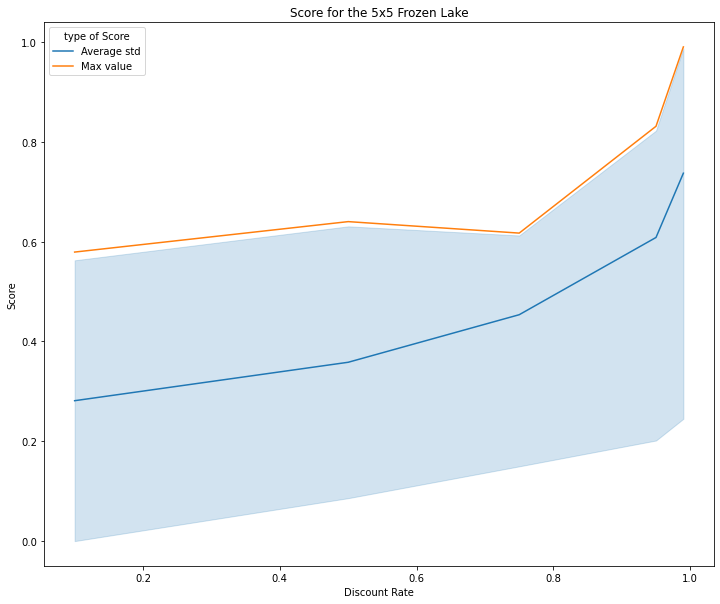

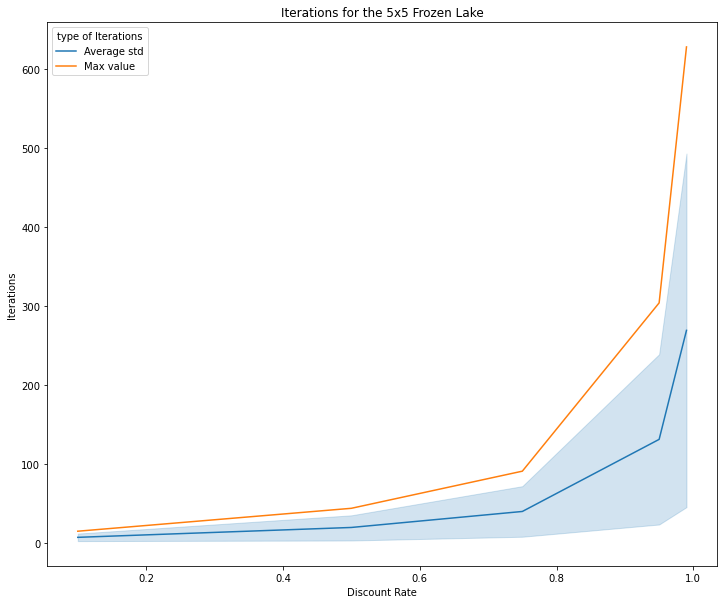

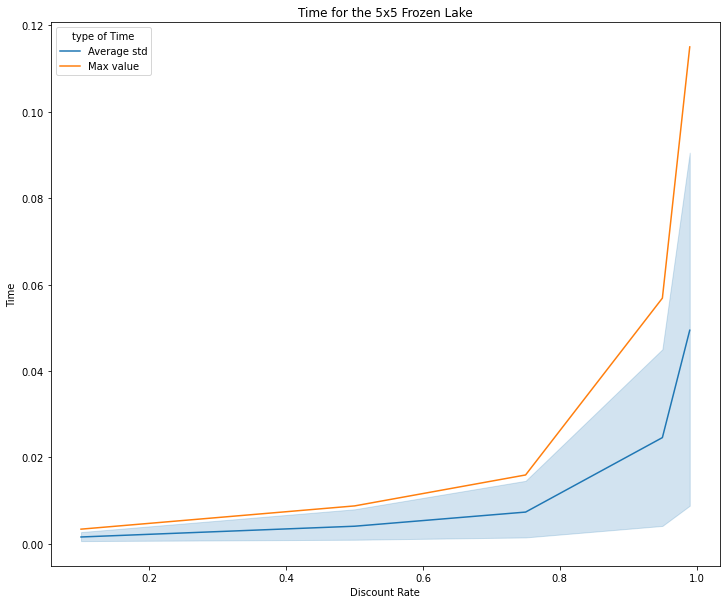

In [94]:
val_iter5_cleaned = convertDictionary(val_iter5)

plotGraph(val_iter5_cleaned[0], val="Score", size=5)
plotGraph(val_iter5_cleaned[1], val="Iterations", size=5)
plotGraph(val_iter5_cleaned[2], val="Time", size=5)

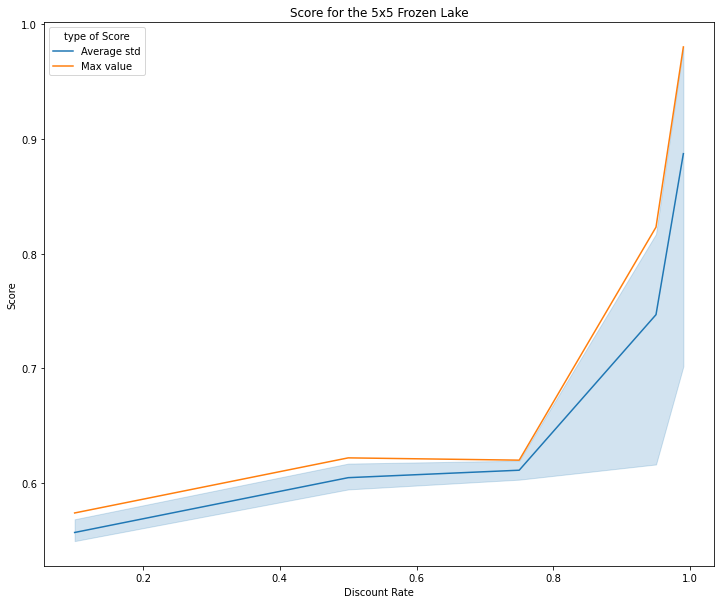

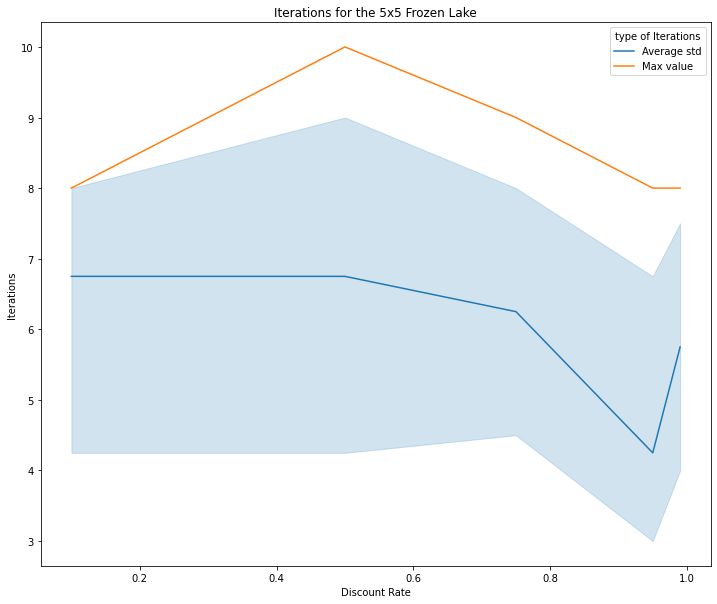

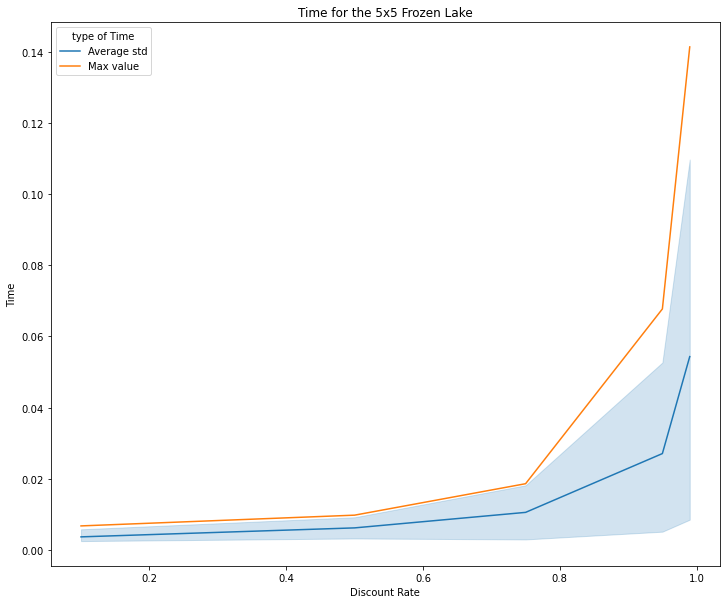

In [95]:
pol_iter5_cleaned = convertDictionary(pol_iter5)

plotGraph(pol_iter5_cleaned[0], val="Score", size=5)
plotGraph(pol_iter5_cleaned[1], val="Iterations", size=5)
plotGraph(pol_iter5_cleaned[2], val="Time", size=5)

In [96]:
env25 = FrozenLakeEnv(desc=twoMaps["25x25"])
val_iter25, pol_iter25 = trainTestVIPI(env25, discounts=[0.1, 0.5, 0.75, 0.95, 0.99], epsilons=[1e-1, 1e-3, 1e-9, 1e-15])

VI: 2 solved episodes; 0:00:00.011849 seconds
Iteration: 2, time: 0:00:00.011849, mean epsilon: 8.902, mean rewards 0.0
VI: 4 solved episodes; 0:00:00.016562 seconds
Iteration: 4, time: 0:00:00.016562, mean epsilon: 8.914, mean rewards 0.0
VI: 9 solved episodes; 0:00:00.038217 seconds
Iteration: 9, time: 0:00:00.038217, mean epsilon: 9.263, mean rewards 0.0
VI: 15 solved episodes; 0:00:00.062194 seconds
Iteration: 15, time: 0:00:00.062194, mean epsilon: 8.629, mean rewards 0.0
VI: 3 solved episodes; 0:00:00.011755 seconds
Iteration: 3, time: 0:00:00.011755, mean epsilon: 9.451, mean rewards 0.0
VI: 8 solved episodes; 0:00:00.038621 seconds
Iteration: 8, time: 0:00:00.038621, mean epsilon: 8.708, mean rewards 0.0
VI: 26 solved episodes; 0:00:00.117994 seconds
Iteration: 26, time: 0:00:00.117994, mean epsilon: 9.044, mean rewards 0.0
VI: 45 solved episodes; 0:00:00.186035 seconds
Iteration: 45, time: 0:00:00.186035, mean epsilon: 9.014, mean rewards 0.0
VI: 3 solved episodes; 0:00:00.013

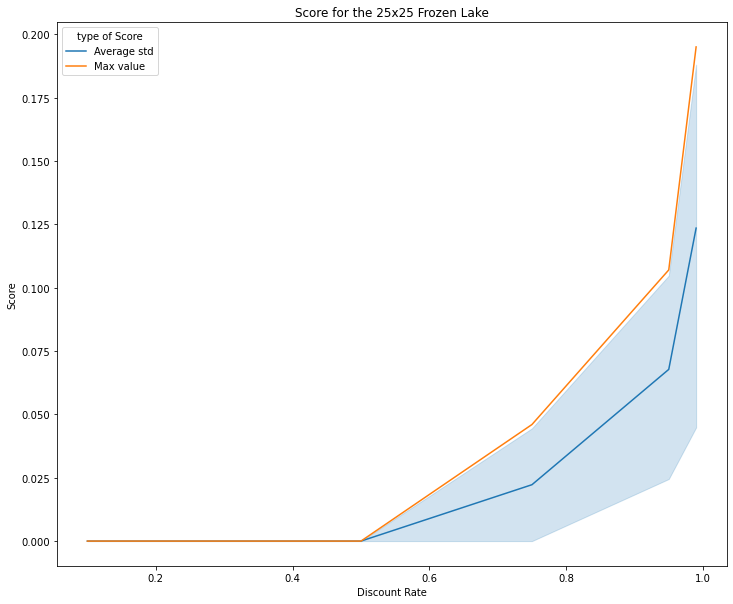

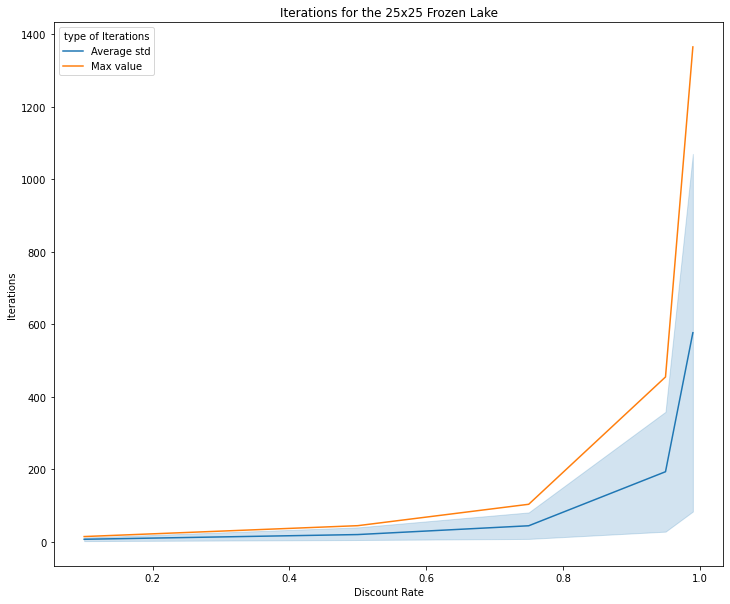

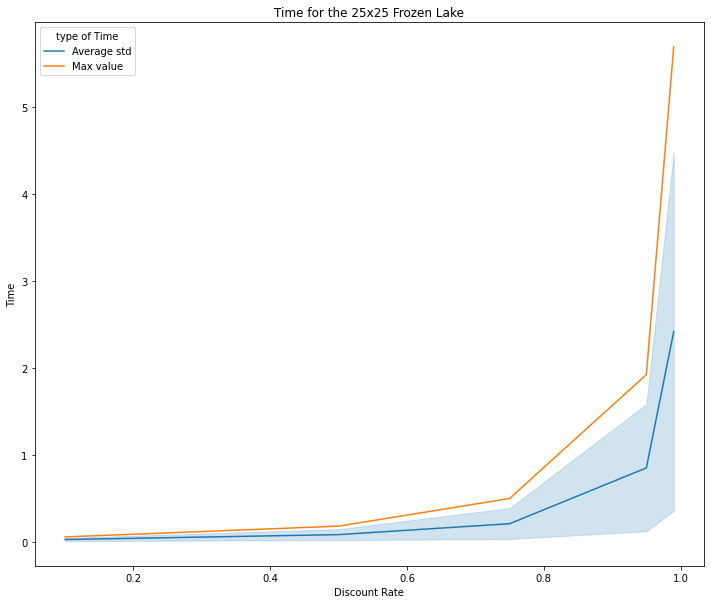

In [97]:
val_iter25_cleaned = convertDictionary(val_iter25)

plotGraph(val_iter25_cleaned[0], val="Score", size=25)
plotGraph(val_iter25_cleaned[1], val="Iterations", size=25)
plotGraph(val_iter25_cleaned[2], val="Time", size=25)

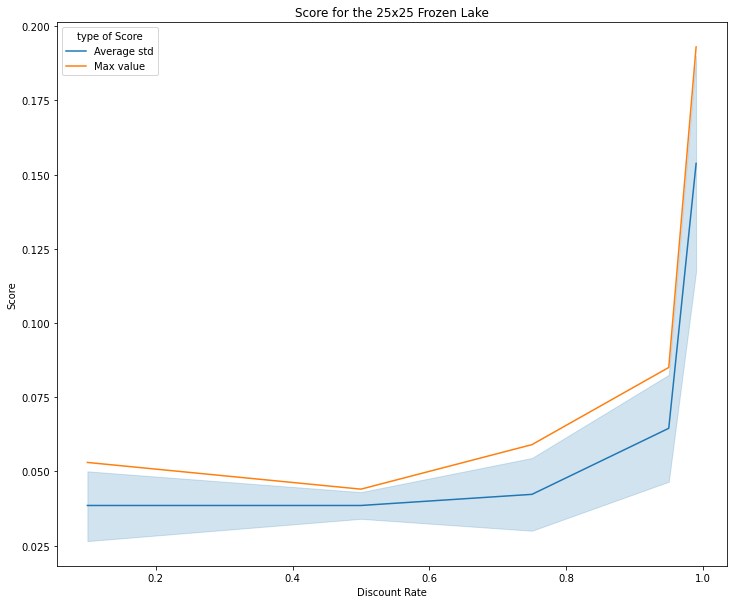

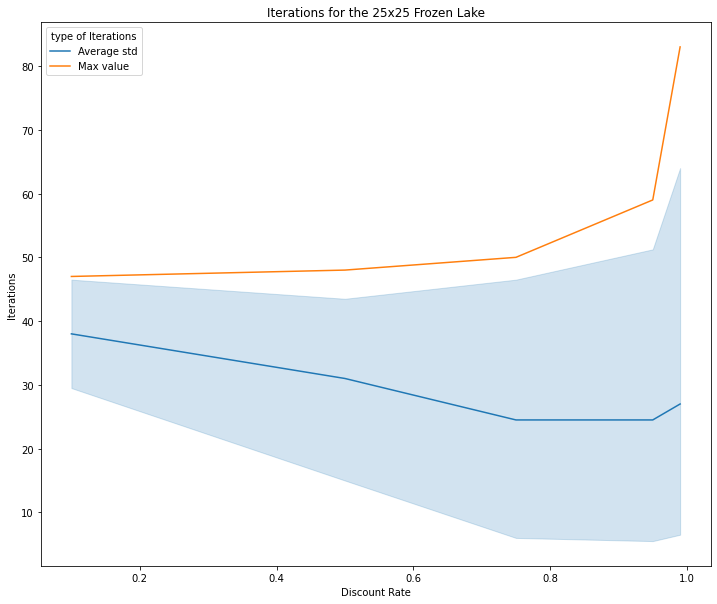

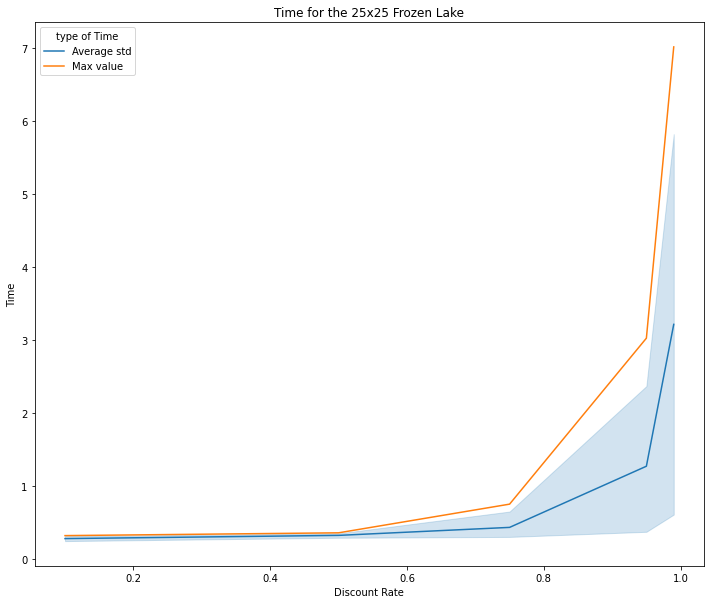

In [98]:
pol_iter25_cleaned = convertDictionary(pol_iter25)

plotGraph(pol_iter25_cleaned[0], val="Score", size=25)
plotGraph(pol_iter25_cleaned[1], val="Iterations", size=25)
plotGraph(pol_iter25_cleaned[2], val="Time", size=25)